# 🛢️ Well Production Simulation with Real Data

This notebook creates and tests well production simulations using actual **Houston basin production data** from:
- **Fact Table**: `houston_fact_combined.csv` - Daily production records
- **Dimension Table**: `qi_di_b_factor_dimension.csv` - Well parameters (Qi, Di, b-factor)

## Contents
1. [Setup & Data Loading](#1.-Setup-&-Data-Loading)
2. [Data Exploration](#2.-Data-Exploration)
3. [Data Preparation](#3.-Data-Preparation)
4. [Create Simulation from Real Data](#4.-Create-Simulation-from-Real-Data)
5. [Compare Simulated vs Actual Production](#5.-Compare-Simulated-vs-Actual-Production)
6. [Forecasting Future Production](#6.-Forecasting-Future-Production)

---
## 1. Setup & Data Loading

In [4]:
# Standard imports
import sys
import math
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Any, Optional

# Data analysis with Polars (fast for large datasets)
import polars as pl
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up paths


# Configure display
pl.Config.set_tbl_rows(20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print(" Standard imports loaded")


 Standard imports loaded


In [5]:
# Load the data using Polars (much faster for large CSV files)
print(" Loading production fact data (this may take a moment for 300+ MB file)...")
fact = pl.read_csv("data\\houston_fact_combined_cleaned.csv")
print(f" Fact table loaded: {fact.shape[0]:,} rows x {fact.shape[1]} columns")

print("\n Loading dimension data...")
dim = pl.read_csv("data\\qi_di_b_factor_dimension.csv")
print(f" Dimension table loaded: {dim.shape[0]:,} rows x {dim.shape[1]} columns")

 Loading production fact data (this may take a moment for 300+ MB file)...
 Fact table loaded: 2,669,582 rows x 14 columns

 Loading dimension data...
 Dimension table loaded: 17,209 rows x 10 columns


In [6]:
# Import simulation modules
try:
    from simulation import SimulationRunner, BasinModel, WellAgent
    from config.simulation_config import (
        WellType, DeclineType, DriveMechanism, WellConfiguration,
        WELL_TYPE_PARAMETERS, CONSTANTS,
    )
    print(" Simulation modules loaded successfully!")
except ImportError as e:
    print(f" Import error: {e}")
    print("   Continuing with data exploration only.")

 Simulation modules loaded successfully!


---
## 2. Data Exploration

In [7]:
# Fact table schema and sample
print(" FACT TABLE - Schema:")
print("=" * 60)
for col in fact.columns:
    dtype = fact[col].dtype
    null_count = fact[col].null_count()
    print(f"  {col:30} {str(dtype):15} (nulls: {null_count:,})")

print("\n Sample rows:")
fact.head(10)

 FACT TABLE - Schema:
  Unnamed: 0                     Int64           (nulls: 0)
  api                            Int64           (nulls: 0)
  basin                          String          (nulls: 0)
  play_type                      String          (nulls: 0)
  latest_production_date         String          (nulls: 0)
  production_vol_date            String          (nulls: 0)
  production_status              String          (nulls: 0)
  start_year                     Int64           (nulls: 0)
  current_month                  Int64           (nulls: 0)
  bopd                           Float64         (nulls: 0)
  country                        String          (nulls: 0)
  market_id                      String          (nulls: 0)
  well_type                      String          (nulls: 0)
  basin_name                     String          (nulls: 0)

 Sample rows:


shape: (10, 14)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Unnamed: 0 ┆ api        ┆ basin ┆ play_type  ┆ … ┆ country   ┆ market_id ┆ well_type ┆ basin_nam │
│ ---        ┆ ---        ┆ ---   ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ e         │
│ i64        ┆ i64        ┆ str   ┆ str        ┆   ┆ str       ┆ str       ┆ str       ┆ ---       │
│            ┆            ┆       ┆            ┆   ┆           ┆           ┆           ┆ str       │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1967147    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967148    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967149    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967150    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967151    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967152    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967153    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967154    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967155    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967156    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
└────────────┴────────────┴───────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [8]:
# Dimension table schema and sample
print(" DIMENSION TABLE - Schema:")
print("=" * 60)
for col in dim.columns:
    dtype = dim[col].dtype
    null_count = dim[col].null_count()
    print(f"  {col:30} {str(dtype):15} (nulls: {null_count:,})")

print("\n Sample rows:")
dim.head(10)

 DIMENSION TABLE - Schema:
  country                        String          (nulls: 0)
  market_id                      String          (nulls: 4)
  basin_name                     String          (nulls: 24)
  sub_basin_name                 String          (nulls: 26)
  well_type                      String          (nulls: 38)
  start_year                     Int64           (nulls: 0)
  Qi                             Float64         (nulls: 1,214)
  Di                             Float64         (nulls: 1,854)
  model                          String          (nulls: 892)
  b_factor                       Float64         (nulls: 892)

 Sample rows:


shape: (10, 10)
┌────────────┬───────────┬────────────┬────────────┬───┬─────────┬──────────┬───────────┬──────────┐
│ country    ┆ market_id ┆ basin_name ┆ sub_basin_ ┆ … ┆ Qi      ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ ---       ┆ ---        ┆ name       ┆   ┆ ---     ┆ ---      ┆ ---       ┆ ---      │
│ str        ┆ str       ┆ str        ┆ ---        ┆   ┆ f64     ┆ f64      ┆ str       ┆ f64      │
│            ┆           ┆            ┆ str        ┆   ┆         ┆          ┆           ┆          │
╞════════════╪═══════════╪════════════╪════════════╪═══╪═════════╪══════════╪═══════════╪══════════╡
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 10530.0 ┆ 0.862826 ┆ null      ┆ null     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ al        ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ AMARILLO   ┆ AMARILLO   ┆ … ┆ 674.5   ┆ 1.608565 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆ UPLIFT     ┆ UPLIFT     ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ AMARILLO   ┆ AMARILLO   ┆ … ┆ 674.5   ┆ 1.608565 ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆           ┆ UPLIFT     ┆ UPLIFT     ┆   ┆         ┆          ┆ al        ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ AMARILLO   ┆ AMARILLO   ┆ … ┆ 674.5   ┆ 1.608565 ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆           ┆ UPLIFT     ┆ UPLIFT     ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ ANADARKO   ┆ ANADARKO   ┆ … ┆ 6223.5  ┆ 1.102895 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆ BASIN      ┆ DEEP       ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆ SUB-BASIN  ┆   ┆         ┆          ┆           ┆          │
│            ┆           ┆            ┆ (ANADA…    ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ ANADARKO   ┆ ANADARKO   ┆ … ┆ 6223.5  ┆ 1.102895 ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆           ┆ BASIN      ┆ DEEP       ┆   ┆         ┆          ┆ al        ┆          │
│ AMERICA    ┆           ┆            ┆ SUB-BASIN  ┆   ┆         ┆          ┆           ┆          │
│            ┆           ┆            ┆ (ANADA…    ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ ANADARKO   ┆ ANADARKO   ┆ … ┆ 6223.5  ┆ 1.102895 ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆           ┆ BASIN      ┆ DEEP       ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆ SUB-BASIN  ┆   ┆         ┆          ┆           ┆          │
│            ┆           ┆            ┆ (ANADA…    ┆   ┆         ┆          ┆           ┆          │
└────────────┴───────────┴────────────┴──────

In [9]:
# Unique values analysis for fact table
print(" FACT TABLE - Key Statistics:")
print("=" * 60)
print(f"Total production records: {fact.shape[0]:,}")
print(f"Unique wells (API): {fact['api'].n_unique():,}")
print(f"\nBasins:")
for basin in fact['basin'].unique().to_list():
    count = fact.filter(pl.col('basin') == basin).shape[0]
    print(f"  - {basin}: {count:,} records")

print(f"\nPlay Types:")
for pt in fact['play_type'].unique().to_list():
    count = fact.filter(pl.col('play_type') == pt).shape[0]
    print(f"  - {pt}: {count:,} records")

print(f"\nProduction Status:")
for status in fact['production_status'].unique().to_list():
    count = fact.filter(pl.col('production_status') == status).shape[0]
    print(f"  - {status}: {count:,} records")

 FACT TABLE - Key Statistics:
Total production records: 2,669,582
Unique wells (API): 1,563

Basins:
  - GULF COAST BASIN: 2,669,582 records

Play Types:
  - CONVENTIONAL OFFSHORE: 11,988 records
  - CONVENTIONAL ONSHORE: 2,657,594 records

Production Status:
  - ACTIVE: 2,669,582 records


In [ ]:
# Date range and production statistics
print(" Date Range Analysis:")
print("=" * 60)

# Convert date strings to dates for analysis
fact_with_dates = fact.with_columns([
    pl.col('production_vol_date').str.to_date().alias('prod_date')
])

min_date = fact_with_dates['prod_date'].min()
max_date = fact_with_dates['prod_date'].max()
print(f"Production date range: {min_date} to {max_date}")

print(f"\n Production Statistics (bopd):")
print(fact['bopd'].describe())

📅 Date Range Analysis:
Production date range: 2020-01-01 to 2025-09-30

 Production Statistics (bopd):
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 2.669582e6  │
│ null_count ┆ 0.0         │
│ mean       ┆ 12.78122    │
│ std        ┆ 31.901505   │
│ min        ┆ 0.032258    │
│ 25%        ┆ 1.032258    │
│ 50%        ┆ 4.655172    │
│ 75%        ┆ 12.857143   │
│ max        ┆ 1128.733333 │
└────────────┴─────────────┘


In [11]:
# Dimension table analysis
print(" DIMENSION TABLE - Key Statistics:")
print("=" * 60)

print(f"\nMarket Centers:")
for market in dim.filter(pl.col('market_id').is_not_null())['market_id'].unique().to_list():
    count = dim.filter(pl.col('market_id') == market).shape[0]
    print(f"  - {market}: {count:,} records")

print(f"\nWell Types:")
for wt in dim.filter(pl.col('well_type').is_not_null())['well_type'].unique().to_list()[:10]:
    count = dim.filter(pl.col('well_type') == wt).shape[0]
    print(f"  - {wt}: {count:,} records")

print(f"\nDecline Models:")
for model in dim.filter(pl.col('model').is_not_null())['model'].unique().to_list():
    count = dim.filter(pl.col('model') == model).shape[0]
    print(f"  - {model}: {count:,} records")

print(f"\nQi Statistics (Initial Production bbl/day):")
print(dim['Qi'].describe())

print(f"\nDi Statistics (Decline Rate):")
print(dim['Di'].describe())

print(f"\nb_factor Statistics:")
print(dim['b_factor'].describe())

 DIMENSION TABLE - Key Statistics:

Market Centers:
  - Bakken: 900 records
  - Corpus Christi: 258 records
  - Permian: 3,046 records
  - rest: 5,202 records
  - Houston: 255 records
  - Eagle Ford: 521 records
  - Rockies: 2,544 records
  - Cushing: 3,204 records
  - Louisiana Gulf Coast: 1,275 records

Well Types:
  - SHALE: 3,327 records
  - CONVENTIONAL ONSHORE: 8,013 records
  - NON OIL AND GAS PRODUCER: 704 records
  - TIGHT: 1,779 records
  - COALBED METHANE: 150 records
  - CONVENTIONAL TIGHT: 2,862 records
  - CONVENTIONAL OFFSHORE: 336 records

Decline Models:
  - harmonic: 5,439 records
  - hyperbolic: 5,439 records
  - exponential: 5,439 records

Qi Statistics (Initial Production bbl/day):
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 15995.0      │
│ null_count ┆ 1214.0       │
│ mean       ┆ 4824.863148  │
│ std        ┆ 19029.827753 │
│ mi

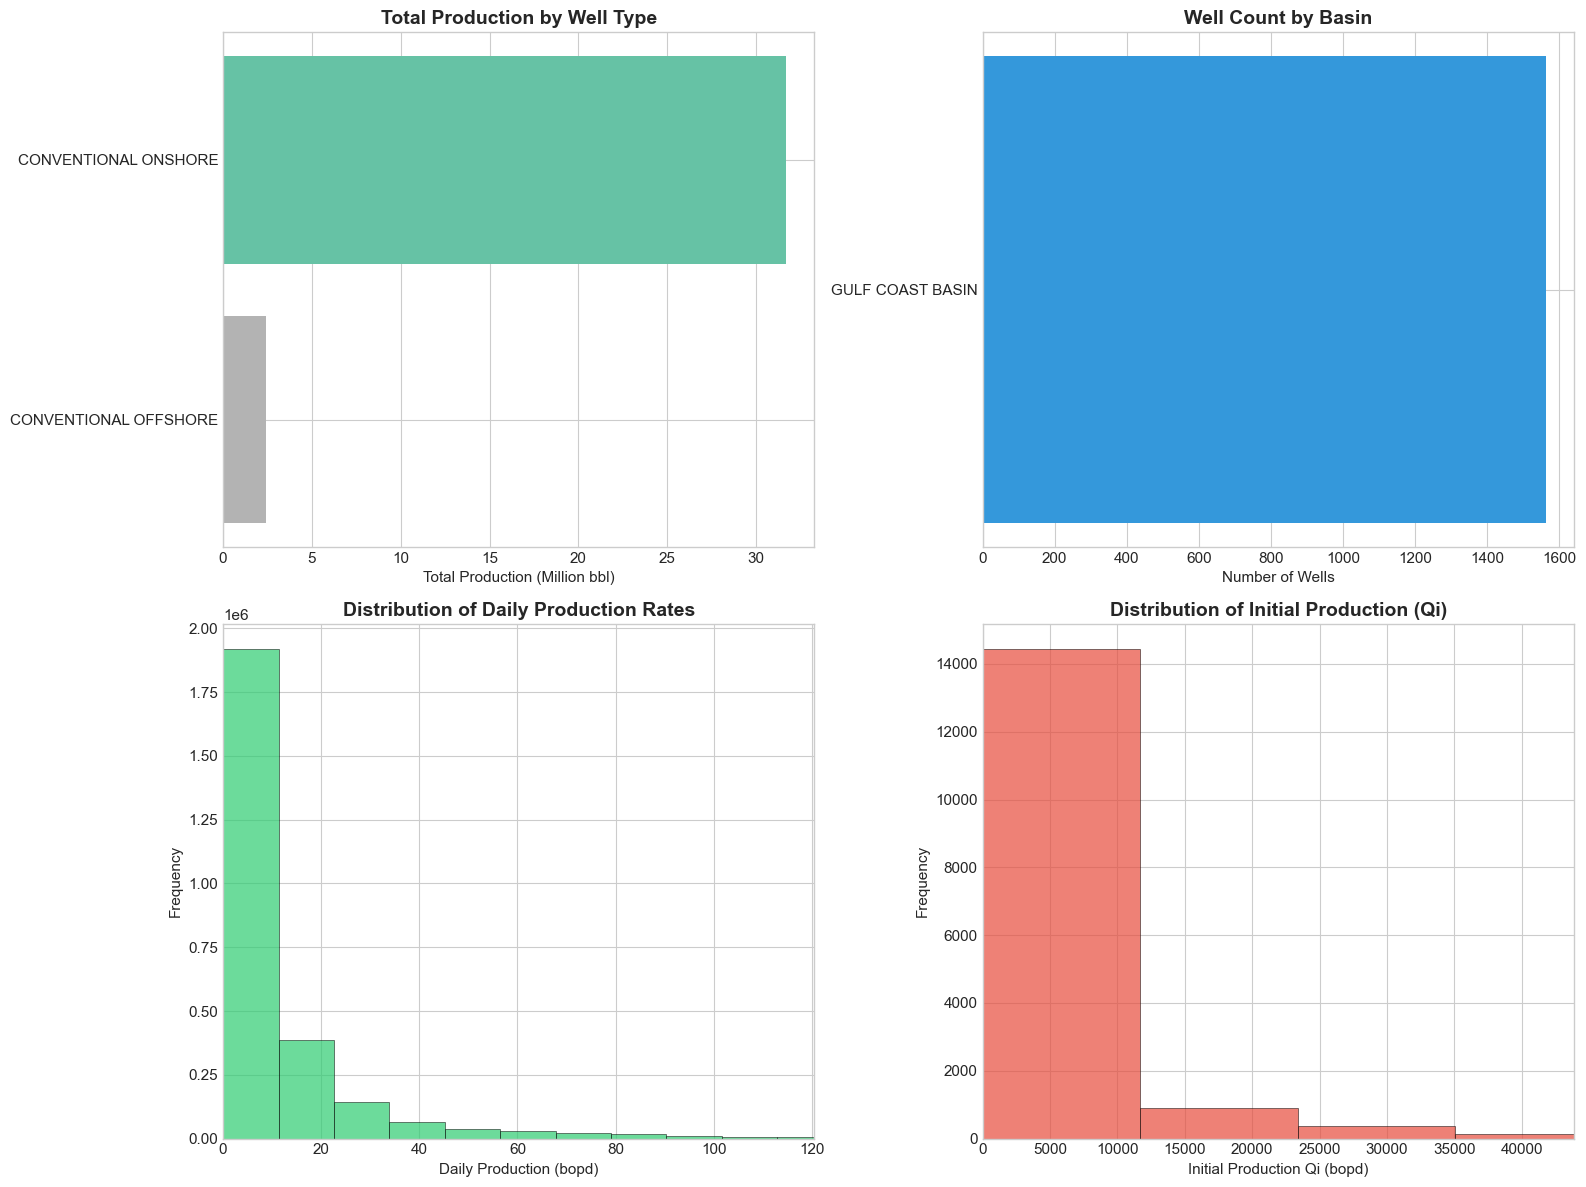

In [12]:
# Visualize production distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Production by well type
ax1 = axes[0, 0]
play_type_prod = (
    fact.group_by('play_type')
    .agg(pl.col('bopd').sum().alias('total_prod'))
    .sort('total_prod', descending=True)
).to_pandas()
colors = plt.cm.Set2(np.linspace(0, 1, len(play_type_prod)))
ax1.barh(play_type_prod['play_type'], play_type_prod['total_prod'] / 1e6, color=colors)
ax1.set_xlabel('Total Production (Million bbl)')
ax1.set_title('Total Production by Well Type', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# 2. Well count by basin
ax2 = axes[0, 1]
basin_wells = (
    fact.group_by('basin')
    .agg(pl.col('api').n_unique().alias('well_count'))
    .sort('well_count', descending=True)
).to_pandas()
ax2.barh(basin_wells['basin'], basin_wells['well_count'], color='#3498db')
ax2.set_xlabel('Number of Wells')
ax2.set_title('Well Count by Basin', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# 3. Production rate distribution
ax3 = axes[1, 0]
bopd_data = fact.filter(pl.col('bopd') > 0)['bopd'].to_numpy()
ax3.hist(bopd_data, bins=100, color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Daily Production (bopd)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Daily Production Rates', fontsize=14, fontweight='bold')
ax3.set_xlim(0, np.percentile(bopd_data, 99))  # Limit to 99th percentile

# 4. Qi distribution from dimension table
ax4 = axes[1, 1]
qi_data = dim.filter(pl.col('Qi').is_not_null())['Qi'].to_numpy()
ax4.hist(qi_data, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=0.5)
ax4.set_xlabel('Initial Production Qi (bopd)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Initial Production (Qi)', fontsize=14, fontweight='bold')
ax4.set_xlim(0, np.percentile(qi_data, 99))

plt.tight_layout()
plt.show()

---
## 3. Data Preparation

Prepare the data for simulation by:
1. Selecting a subset of wells for testing
2. Getting decline parameters from dimension table
3. Creating historical production dictionary

In [13]:
# Get Houston market center parameters
houston_dim = dim.filter(
    (pl.col('market_id') == 'Houston') | 
    (pl.col('basin_name').str.contains('GULF COAST'))
)

print(f" Houston/Gulf Coast dimension records: {houston_dim.shape[0]}")
houston_dim.head(20)

 Houston/Gulf Coast dimension records: 3013


shape: (20, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬─────────┬───────────┬───────────┬──────────┐
│ country    ┆ market_id  ┆ basin_nam ┆ sub_basin ┆ … ┆ Qi      ┆ Di        ┆ model     ┆ b_factor │
│ ---        ┆ ---        ┆ e         ┆ _name     ┆   ┆ ---     ┆ ---       ┆ ---       ┆ ---      │
│ str        ┆ str        ┆ ---       ┆ ---       ┆   ┆ f64     ┆ f64       ┆ str       ┆ f64      │
│            ┆            ┆ str       ┆ str       ┆   ┆         ┆           ┆           ┆          │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═════════╪═══════════╪═══════════╪══════════╡
│ UNITED     ┆ Louisiana  ┆ GULF      ┆ ANGELINA- ┆ … ┆ 3420.0  ┆ 1.080766  ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆ Gulf Coast ┆ COAST     ┆ WIGGINS   ┆   ┆         ┆           ┆ c         ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ FLEXURE   ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ ZONE …    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ Louisiana  ┆ GULF      ┆ ANGELINA- ┆ … ┆ 3420.0  ┆ 1.080766  ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆ Gulf Coast ┆ COAST     ┆ WIGGINS   ┆   ┆         ┆           ┆ al        ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ FLEXURE   ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ ZONE …    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ Louisiana  ┆ GULF      ┆ ANGELINA- ┆ … ┆ 3420.0  ┆ 1.080766  ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆ Gulf Coast ┆ COAST     ┆ WIGGINS   ┆   ┆         ┆           ┆           ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ FLEXURE   ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ ZONE …    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ Louisiana  ┆ GULF      ┆ ANGELINA- ┆ … ┆ 578.0   ┆ 0.739162  ┆ hyperboli ┆ 0.6      │
│ STATES OF  ┆ Gulf Coast ┆ COAST     ┆ WIGGINS   ┆   ┆         ┆           ┆ c         ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ FLEXURE   ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ ZONE …    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ Louisiana  ┆ GULF      ┆ ANGELINA- ┆ … ┆ 578.0   ┆ 0.739162  ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆ Gulf Coast ┆ COAST     ┆ WIGGINS   ┆   ┆         ┆           ┆ al        ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ FLEXURE   ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ ZONE …    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ Louisiana  ┆ GULF      ┆ ANGELINA- ┆ … ┆ 578.0   ┆ 0.739162  ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆ Gulf Coast ┆ COAST     ┆ WIGGINS   ┆   ┆         ┆           ┆           ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ FLEXURE   ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ ZONE …    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ rest       ┆ GULF      ┆ APALACHIC ┆ … ┆ 1948.5  ┆ 0.966528  ┆ hyperboli ┆ 0.75     │
│ STATES OF  ┆            ┆ COAST     ┆ OLA BASIN ┆   ┆         ┆           ┆ c         ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ (GULF     ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ COAST…    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ rest       ┆ GULF      ┆ APALACHIC ┆ … ┆ 1948.5  ┆ 0.966528  ┆ exponenti ┆ 0.04     │
│ STATES OF  ┆            ┆ COAST     ┆ OLA BASIN ┆   ┆         ┆           ┆ al        ┆          │
│ AMERICA    ┆            ┆ BASIN     ┆ (GULF     ┆   ┆         ┆           ┆           ┆          │
│            ┆            ┆           ┆ COAST…    ┆   ┆         ┆           ┆           ┆          │
│ UNITED     ┆ rest       ┆ GULF      ┆ APALACHIC ┆ … ┆ 1948.5  ┆ 0.966528  ┆ harmonic  ┆ 1.015    │
│ STATES OF  ┆            ┆ COAST     ┆ OLA B

In [14]:
# Get unique wells with their first and last production dates
well_summary = (
    fact_with_dates
    .group_by('api')
    .agg([
        pl.col('prod_date').min().alias('first_prod_date'),
        pl.col('prod_date').max().alias('last_prod_date'),
        pl.col('bopd').first().alias('first_bopd'),
        pl.col('bopd').last().alias('last_bopd'),
        pl.col('bopd').mean().alias('avg_bopd'),
        pl.col('bopd').max().alias('max_bopd'),
        pl.col('bopd').sum().alias('total_oil'),
        pl.col('play_type').first().alias('play_type'),
        pl.col('basin').first().alias('basin'),
        pl.col('production_status').last().alias('status'),
        pl.len().alias('record_count'),
    ])
    .sort('total_oil', descending=True)
)

print(f" Total unique wells: {well_summary.shape[0]:,}")
print("\n🔝 Top 20 wells by total production:")
well_summary.head(20)

 Total unique wells: 1,563

🔝 Top 20 wells by total production:


shape: (20, 12)
┌────────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────┬────────────┐
│ api        ┆ first_prod ┆ last_prod_ ┆ first_bopd ┆ … ┆ play_type  ┆ basin ┆ status ┆ record_cou │
│ ---        ┆ _date      ┆ date       ┆ ---        ┆   ┆ ---        ┆ ---   ┆ ---    ┆ nt         │
│ i64        ┆ ---        ┆ ---        ┆ f64        ┆   ┆ str        ┆ str   ┆ str    ┆ ---        │
│            ┆ date       ┆ date       ┆            ┆   ┆            ┆       ┆        ┆ u32        │
╞════════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════╪════════════╡
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 816.709677 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0002       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-30 ┆ 723.612903 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1310       │
│ 0200       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-31 ┆ 737.774194 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1370       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203933304 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 439.709677 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2100       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4220132986 ┆ 2021-05-01 ┆ 2025-03-31 ┆ 449.483871 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1431       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4270640476 ┆ 2022-04-01 ┆ 2025-09-30 ┆ 266.233333 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1279       │
│ 0600       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4203933080 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 202.612903 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901118 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 254.870968 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901084 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 177.096774 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901060 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 164.0      ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901119 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 140.16129  ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901075 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 178.

In [15]:
# Get decline parameters for hyperbolic model by well type (Houston/Gulf Coast specific)
decline_params = (
    dim
    .filter(
        (pl.col('model') == 'hyperbolic') &
        pl.col('well_type').is_not_null() &
        pl.col('Qi').is_not_null() &
        pl.col('Di').is_not_null()
    )
    .group_by('well_type')
    .agg([
        pl.col('Qi').mean().alias('avg_Qi'),
        pl.col('Di').mean().alias('avg_Di'),
        pl.col('b_factor').mean().alias('avg_b'),
        pl.len().alias('count'),
    ])
    .sort('count', descending=True)
)

print(" Average Decline Parameters by Well Type (Hyperbolic):")
decline_params

 Average Decline Parameters by Well Type (Hyperbolic):


shape: (5, 5)
┌───────────────────────┬──────────────┬──────────┬───────┬───────┐
│ well_type             ┆ avg_Qi       ┆ avg_Di   ┆ avg_b ┆ count │
│ ---                   ┆ ---          ┆ ---      ┆ ---   ┆ ---   │
│ str                   ┆ f64          ┆ f64      ┆ f64   ┆ u32   │
╞═══════════════════════╪══════════════╪══════════╪═══════╪═══════╡
│ CONVENTIONAL ONSHORE  ┆ 2904.674328  ┆ 0.581752 ┆ 0.45  ┆ 2454  │
│ SHALE                 ┆ 7658.948496  ┆ 1.038139 ┆ 1.05  ┆ 931   │
│ CONVENTIONAL TIGHT    ┆ 3359.987345  ┆ 0.930199 ┆ 0.6   ┆ 889   │
│ TIGHT                 ┆ 2184.825     ┆ 0.91163  ┆ 0.75  ┆ 530   │
│ CONVENTIONAL OFFSHORE ┆ 64063.932243 ┆ 0.388662 ┆ 0.35  ┆ 107   │
└───────────────────────┴──────────────┴──────────┴───────┴───────┘

In [16]:
def map_play_type_to_well_type(play_type: str) -> str:
    """
    Map production data play_type to simulation well_type.
    """
    mapping = {
        'CONVENTIONAL ONSHORE': 'Conventional Onshore',
        'CONVENTIONAL OFFSHORE': 'Conventional Offshore',
        'SHALE': 'Shale Oil',
        'SHALE OIL': 'Shale Oil',
        'TIGHT': 'Tight Oil',
        'TIGHT OIL': 'Tight Oil',
        'CONVENTIONAL TIGHT': 'Conventional Tight',
    }
    return mapping.get(play_type.upper(), 'Conventional Onshore')


def get_decline_params_for_type(well_type: str, decline_params_df: pl.DataFrame) -> Dict[str, float]:
    """
    Get average decline parameters for a well type from dimension data.
    """
    # Map display name to data format
    type_mapping = {
        'Conventional Onshore': 'CONVENTIONAL ONSHORE',
        'Conventional Offshore': 'CONVENTIONAL OFFSHORE',
        'Shale Oil': 'SHALE',
        'Tight Oil': 'TIGHT',
        'Conventional Tight': 'CONVENTIONAL TIGHT',
    }
    
    data_type = type_mapping.get(well_type, 'CONVENTIONAL ONSHORE')
    
    match = decline_params_df.filter(pl.col('well_type') == data_type)
    
    if match.shape[0] > 0:
        row = match.row(0, named=True)
        return {
            'Qi': row['avg_Qi'],
            'Di': row['avg_Di'],
            'b': row['avg_b'] if row['avg_b'] else 0.5,
        }
    else:
        # Defaults if no data
        return {'Qi': 100.0, 'Di': 0.3, 'b': 0.5}

print(" Helper functions defined")

 Helper functions defined


In [17]:
# Select a sample of wells for simulation testing
# Choose wells with good data coverage (many records) and different types

# Get top wells from each play type
sample_wells = []

for play_type in well_summary['play_type'].unique().to_list():
    type_wells = (
        well_summary
        .filter(
            (pl.col('play_type') == play_type) &
            (pl.col('record_count') > 100) &  # At least 100 days of data
            (pl.col('status') == 'ACTIVE')     # Currently active
        )
        .head(3)  # Top 3 from each type
    )
    sample_wells.append(type_wells)

sample_wells_df = pl.concat(sample_wells).head(10)  # Limit to 10 wells total

print(f" Selected {sample_wells_df.shape[0]} sample wells for simulation:")
sample_wells_df

 Selected 6 sample wells for simulation:


shape: (6, 12)
┌────────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────┬────────────┐
│ api        ┆ first_prod ┆ last_prod_ ┆ first_bopd ┆ … ┆ play_type  ┆ basin ┆ status ┆ record_cou │
│ ---        ┆ _date      ┆ date       ┆ ---        ┆   ┆ ---        ┆ ---   ┆ ---    ┆ nt         │
│ i64        ┆ ---        ┆ ---        ┆ f64        ┆   ┆ str        ┆ str   ┆ str    ┆ ---        │
│            ┆ date       ┆ date       ┆            ┆   ┆            ┆       ┆        ┆ u32        │
╞════════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════╪════════════╡
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-31 ┆ 737.774194 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1370       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203933304 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 439.709677 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2100       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4220132986 ┆ 2021-05-01 ┆ 2025-03-31 ┆ 449.483871 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1431       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 816.709677 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0002       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-30 ┆ 723.612903 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1310       │
│ 0200       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4270640476 ┆ 2022-04-01 ┆ 2025-09-30 ┆ 266.233333 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1279       │
│ 0600       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
└────────────┴────────────┴────────────┴────────────┴───┴────────────┴───────┴────────┴────────────┘

In [18]:
def get_well_historical_production(api: int, fact_df: pl.DataFrame) -> Dict[str, float]:
    """
    Get historical production data for a well as a dictionary.
    Format: {"YYYY-MM-DD": production_value}
    """
    well_data = fact_df.filter(pl.col('api') == api)
    
    production_dict = {}
    for row in well_data.iter_rows(named=True):
        date_str = row['production_vol_date']
        bopd = row['bopd']
        if date_str and bopd is not None:
            production_dict[date_str] = float(bopd)
    
    return production_dict


def prepare_well_config(api: int, well_info: Dict, fact_df: pl.DataFrame, decline_params_df: pl.DataFrame) -> Dict[str, Any]:
    """
    Prepare well configuration for simulation from real data.
    """
    # Map play type to simulation well type
    well_type = map_play_type_to_well_type(well_info['play_type'])
    
    # Get decline parameters
    params = get_decline_params_for_type(well_type, decline_params_df)
    
    # Get historical production
    historical_production = get_well_historical_production(api, fact_df)
    
    # Get first production as initial production estimate
    initial_production = well_info.get('max_bopd', params['Qi']) or params['Qi']
    
    # Parse first production date
    first_date = well_info.get('first_prod_date')
    if isinstance(first_date, str):
        production_start_date = datetime.strptime(first_date, '%Y-%m-%d')
    elif hasattr(first_date, 'year'):
        production_start_date = datetime(first_date.year, first_date.month, first_date.day)
    else:
        production_start_date = datetime(2020, 1, 1)
    
    return {
        'api_number': api,
        'well_type': well_type,
        'initial_production': float(initial_production),
        'b_factor': params['b'],
        'nominal_decline_rate': params['Di'],
        'decline_type': 'Hyperbolic',
        'location': well_info.get('basin', 'Gulf Coast'),
        'basin': well_info.get('basin', 'Gulf Coast'),
        'production_start_date': production_start_date,
        'actual_production_data': historical_production,
        'is_new': False,  # This is an existing well from data
    }

print(" Well preparation functions defined")

 Well preparation functions defined


In [19]:
# Prepare configurations for sample wells
well_configs = []

for row in sample_wells_df.iter_rows(named=True):
    api = row['api']
    config = prepare_well_config(api, row, fact, decline_params)
    well_configs.append(config)
    print(f" Prepared well {api}: {config['well_type']}, Qi={config['initial_production']:.0f} bopd")

print(f"\n Total wells prepared: {len(well_configs)}")

 Prepared well 42201329880000: Conventional Onshore, Qi=968 bopd
 Prepared well 42039333040000: Conventional Onshore, Qi=442 bopd
 Prepared well 42201329860000: Conventional Onshore, Qi=1095 bopd
 Prepared well 42706404270002: Conventional Offshore, Qi=828 bopd
 Prepared well 42706404780200: Conventional Offshore, Qi=1129 bopd
 Prepared well 42706404760600: Conventional Offshore, Qi=719 bopd

 Total wells prepared: 6


---
## 4. Create Simulation from Real Data

In [31]:
# Define simulation period
# Use the data range from fact table
min_date = fact_with_dates['prod_date'].min()
max_date = fact_with_dates['prod_date'].max()

# For simulation, use a 1-year period within the data range
SIM_START = datetime(2024, 1, 1)
SIM_END = datetime(2024, 12, 31)

print(f" Data available: {min_date} to {max_date}")
print(f" Simulation period: {SIM_START.date()} to {SIM_END.date()}")
print(f" Days to simulate: {(SIM_END - SIM_START).days}")

 Data available: 2020-01-01 to 2025-09-30
 Simulation period: 2024-01-01 to 2024-12-31
 Days to simulate: 365


In [21]:
# Create the simulation runner
try:
    runner = SimulationRunner(
        total_recoverable_resources=6_269_570_000,  # From reserves.csv
        start_date=SIM_START,
        end_date=SIM_END,
        basin_name='Houston Embayment (Gulf Coast Basin)',
        market_center='Houston',
        country='US',
    )
    print(" SimulationRunner created!")
    print(f"   Total steps: {runner.total_steps}")
except Exception as e:
    print(f" Error creating runner: {e}")
    runner = None

No reserves data available for market_center='Houston'. Reserves tracking disabled.


 SimulationRunner created!
   Total steps: 365


In [22]:
# Add wells to simulation
if runner:
    print("➕ Adding wells to simulation...")
    added_wells = []
    
    for config in well_configs:
        try:
            # Adjust start date if well started before simulation
            if config['production_start_date'] > SIM_START:
                config['production_start_date'] = SIM_START
            
            well_state = runner.add_well(**config)
            added_wells.append({
                'api': config['api_number'],
                'id': well_state['id'],
                'type': config['well_type'],
            })
            print(f"   API {config['api_number']}: {config['well_type']} (ID: {well_state['id']})")
        except Exception as e:
            print(f"   API {config['api_number']}: {e}")
    
    print(f"\n Total wells added: {len(added_wells)}")

➕ Adding wells to simulation...
   API 42201329880000: Conventional Onshore (ID: 2)
   API 42039333040000: Conventional Onshore (ID: 3)
   API 42201329860000: Conventional Onshore (ID: 4)
   API 42706404270002: Conventional Offshore (ID: 5)
   API 42706404780200: Conventional Offshore (ID: 6)
   API 42706404760600: Conventional Offshore (ID: 7)

 Total wells added: 6


In [23]:
# Run the simulation
if runner:
    print("🚀 Running simulation...")
    
    # Store results
    sim_results = []
    
    runner.start()
    step = 0
    
    while runner.model.simulation_active:
        state = runner.step()
        step += 1
        
        sim_state = state['state']
        
        # Store daily results
        sim_results.append({
            'date': sim_state['current_date'],
            'daily_production': sum(w['daily_production'] for w in sim_state['basin']['wells']),
            'potential_production': sum(w['daily_potential_production'] for w in sim_state['basin']['wells']),
            'cumulative': sim_state['basin']['cumulative_production'],
            'active_wells': sum(1 for w in sim_state['basin']['wells'] if w['is_active']),
        })
        
        # Progress update
        if step % 30 == 0:
            print(f"  Day {step}: Daily prod = {sim_results[-1]['daily_production']:,.0f} bbl")
    
    print(f"\n Simulation complete! {step} days simulated.")
    
    # Convert to DataFrame
    sim_df = pd.DataFrame(sim_results)
    sim_df['date'] = pd.to_datetime(sim_df['date'])
    sim_df.set_index('date', inplace=True)

🚀 Running simulation...
  Day 30: Daily prod = 961 bbl

📊 MONTHLY PRODUCTION BY GRADE - January 2024
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):         2,384.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):         5,351.00 bbl
   Light Sweet (lSweet):       22,069.00 bbl
   ────────────────────────────────────────
   TOTAL:                      29,804.00 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2024
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):         3,631.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):         5,623.00 bbl
   Light Sweet (lSweet):       22,272.00 bbl
   ────────────────────────────────────────
   TOTAL:                      31,526.00 bbl

  Day 60: Daily prod = 1,087 bbl
  Day 90: Daily prod = 929 bbl

📊 MONTHLY PRODU

---
## 5. Compare Simulated vs Actual Production

In [24]:
# Get actual production for the same wells in the same period
if runner:
    sample_apis = [w['api'] for w in added_wells]
    
    actual_prod = (
        fact_with_dates
        .filter(
            (pl.col('api').is_in(sample_apis)) &
            (pl.col('prod_date') >= SIM_START.date()) &
            (pl.col('prod_date') <= SIM_END.date())
        )
        .group_by('prod_date')
        .agg(pl.col('bopd').sum().alias('actual_production'))
        .sort('prod_date')
    ).to_pandas()
    
    actual_prod['prod_date'] = pd.to_datetime(actual_prod['prod_date'])
    actual_prod.set_index('prod_date', inplace=True)
    
    print(f" Actual production records: {len(actual_prod)}")
    actual_prod.head()

 Actual production records: 366


In [25]:
# Merge simulated and actual production
if runner and len(actual_prod) > 0:
    comparison_df = sim_df[['daily_production']].join(actual_prod, how='outer')
    comparison_df.columns = ['Simulated', 'Actual']
    comparison_df = comparison_df.dropna(how='all')
    
    # Fill NaN with 0 for comparison
    comparison_df = comparison_df.fillna(0)
    
    print(" Comparison DataFrame:")
    comparison_df.head(20)

 Comparison DataFrame:


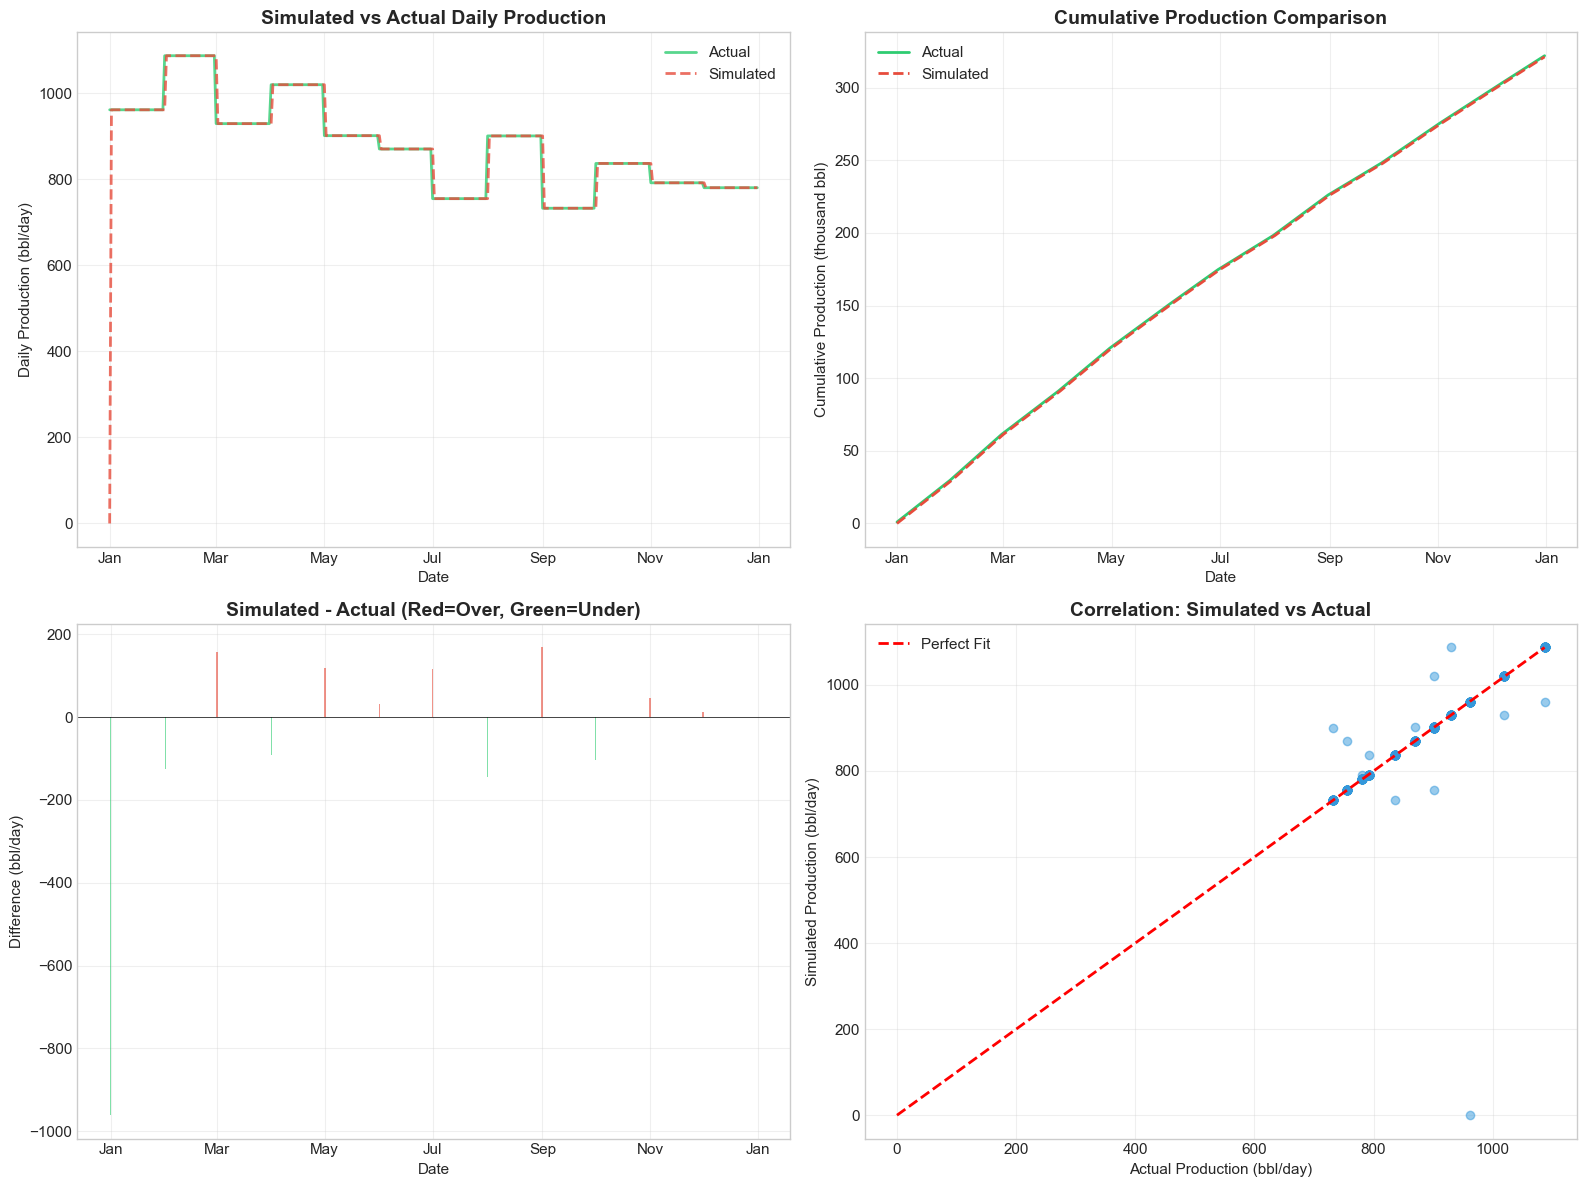


 Comparison Statistics:
Total Simulated: 321,180 bbl
Total Actual: 321,960 bbl
Difference: -780 bbl
MAPE: 0.62%
Correlation: 0.8788


In [26]:
# Visualize comparison
if runner and len(actual_prod) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Daily production comparison
    ax1 = axes[0, 0]
    ax1.plot(comparison_df.index, comparison_df['Actual'], label='Actual', 
             color='#2ecc71', linewidth=2, alpha=0.8)
    ax1.plot(comparison_df.index, comparison_df['Simulated'], label='Simulated', 
             color='#e74c3c', linewidth=2, alpha=0.8, linestyle='--')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Production (bbl/day)')
    ax1.set_title('Simulated vs Actual Daily Production', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative production comparison
    ax2 = axes[0, 1]
    sim_cumulative = comparison_df['Simulated'].cumsum()
    actual_cumulative = comparison_df['Actual'].cumsum()
    ax2.plot(comparison_df.index, actual_cumulative / 1000, label='Actual', 
             color='#2ecc71', linewidth=2)
    ax2.plot(comparison_df.index, sim_cumulative / 1000, label='Simulated', 
             color='#e74c3c', linewidth=2, linestyle='--')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Production (thousand bbl)')
    ax2.set_title('Cumulative Production Comparison', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.grid(True, alpha=0.3)
    
    # 3. Error/Difference
    ax3 = axes[1, 0]
    error = comparison_df['Simulated'] - comparison_df['Actual']
    colors = ['#e74c3c' if e > 0 else '#2ecc71' for e in error]
    ax3.bar(comparison_df.index, error, color=colors, alpha=0.6, width=1)
    ax3.axhline(y=0, color='black', linewidth=0.5)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Difference (bbl/day)')
    ax3.set_title('Simulated - Actual (Red=Over, Green=Under)', fontsize=14, fontweight='bold')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax3.grid(True, alpha=0.3)
    
    # 4. Scatter plot correlation
    ax4 = axes[1, 1]
    ax4.scatter(comparison_df['Actual'], comparison_df['Simulated'], alpha=0.5, c='#3498db')
    max_val = max(comparison_df['Actual'].max(), comparison_df['Simulated'].max())
    ax4.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Fit')
    ax4.set_xlabel('Actual Production (bbl/day)')
    ax4.set_ylabel('Simulated Production (bbl/day)')
    ax4.set_title('Correlation: Simulated vs Actual', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n Comparison Statistics:")
    print("=" * 50)
    print(f"Total Simulated: {comparison_df['Simulated'].sum():,.0f} bbl")
    print(f"Total Actual: {comparison_df['Actual'].sum():,.0f} bbl")
    print(f"Difference: {comparison_df['Simulated'].sum() - comparison_df['Actual'].sum():,.0f} bbl")
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mask = comparison_df['Actual'] > 0
    if mask.sum() > 0:
        mape = (abs(error[mask]) / comparison_df['Actual'][mask]).mean() * 100
        print(f"MAPE: {mape:.2f}%")
    
    # Correlation
    correlation = comparison_df['Simulated'].corr(comparison_df['Actual'])
    print(f"Correlation: {correlation:.4f}")

---
## 6. Forecasting Future Production

Use the simulation to forecast production beyond the available data.

In [27]:
# Create a forecast simulation for 2025-2026
FORECAST_START = datetime(2025, 1, 1)
FORECAST_END = datetime(2026, 12, 31)

print(f" Forecast period: {FORECAST_START.date()} to {FORECAST_END.date()}")

try:
    forecast_runner = SimulationRunner(
        total_recoverable_resources=6_269_570_000,
        start_date=FORECAST_START,
        end_date=FORECAST_END,
        basin_name='Houston Embayment (Gulf Coast Basin)',
        market_center='Houston',
        country='US',
    )
    
    # Add the same wells with adjusted start dates
    for config in well_configs:
        forecast_config = config.copy()
        # Wells already exist, so they start at the beginning of forecast
        forecast_config['production_start_date'] = FORECAST_START
        # Remove historical data for pure decline curve forecast
        forecast_config['actual_production_data'] = {}
        forecast_config['is_new'] = True
        forecast_runner.add_well(**forecast_config)
    
    print(f" Forecast runner created with {forecast_runner.count_wells_in_simulation_range()} wells")
except Exception as e:
    print(f" Error: {e}")
    forecast_runner = None

No reserves data available for market_center='Houston'. Reserves tracking disabled.


📅 Forecast period: 2025-01-01 to 2026-12-31
 Forecast runner created with 6 wells


In [28]:
# Run forecast simulation
if forecast_runner:
    print("🚀 Running forecast simulation...")
    
    forecast_results = []
    forecast_runner.start()
    step = 0
    
    while forecast_runner.model.simulation_active:
        state = forecast_runner.step()
        step += 1
        
        sim_state = state['state']
        forecast_results.append({
            'date': sim_state['current_date'],
            'daily_production': sum(w['daily_production'] for w in sim_state['basin']['wells']),
            'cumulative': sim_state['basin']['cumulative_production'],
        })
        
        if step % 90 == 0:
            print(f"  Day {step}: Daily prod = {forecast_results[-1]['daily_production']:,.0f} bbl")
    
    print(f"\n Forecast complete! {step} days.")
    
    forecast_df = pd.DataFrame(forecast_results)
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])
    forecast_df.set_index('date', inplace=True)

🚀 Running forecast simulation...

📊 MONTHLY PRODUCTION BY GRADE - January 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):        25,244.60 bbl
   Medium Sweet(mSweet):       13,368.39 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):      118,689.89 bbl
   ────────────────────────────────────────
   TOTAL:                     157,302.87 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):        22,104.51 bbl
   Medium Sweet(mSweet):       11,531.75 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):      103,115.65 bbl
   ────────────────────────────────────────
   TOTAL:                     136,751.91 bbl


📊 MONTHLY PRODUCTION BY GRADE - March 2025
   Market Center: Houston
   Heavy Sour  (hSour):         

C:\Users\bhargavesh.dakka\AppData\Local\Temp\ipykernel_20704\1910846424.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_forecast = forecast_df['daily_production'].resample('M').sum()


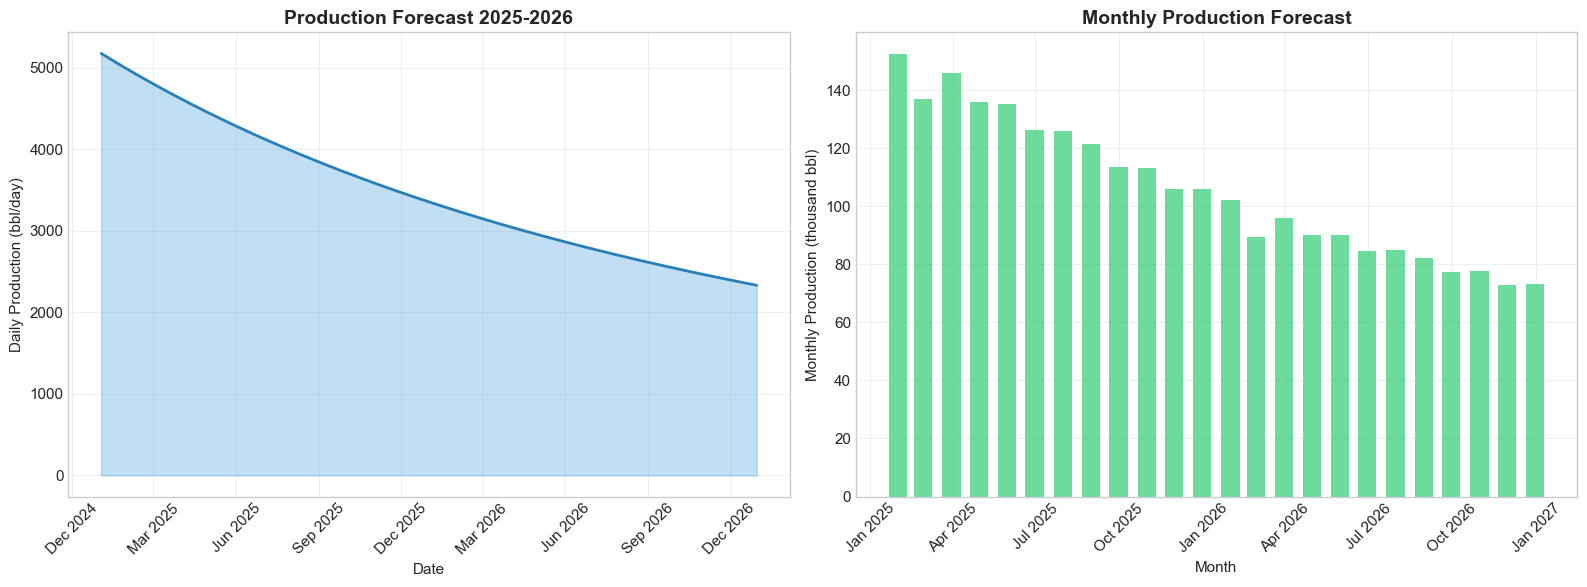


 Forecast Summary:
2025 Total: 1,518,408 bbl
2026 Total: 1,021,580 bbl

Start rate: 5,175 bbl/day
End rate: 2,332 bbl/day
Decline: 54.9%


In [29]:
# Visualize forecast
if forecast_runner:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Daily production forecast
    ax1 = axes[0]
    ax1.fill_between(forecast_df.index, forecast_df['daily_production'], alpha=0.3, color='#3498db')
    ax1.plot(forecast_df.index, forecast_df['daily_production'], color='#2980b9', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Production (bbl/day)')
    ax1.set_title('Production Forecast 2025-2026', fontsize=14, fontweight='bold')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Monthly forecast
    ax2 = axes[1]
    monthly_forecast = forecast_df['daily_production'].resample('M').sum()
    ax2.bar(monthly_forecast.index, monthly_forecast.values / 1000, color='#2ecc71', alpha=0.7, width=20)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Monthly Production (thousand bbl)')
    ax2.set_title('Monthly Production Forecast', fontsize=14, fontweight='bold')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print forecast summary
    print("\n Forecast Summary:")
    print("=" * 50)
    print(f"2025 Total: {forecast_df.loc['2025']['daily_production'].sum():,.0f} bbl")
    print(f"2026 Total: {forecast_df.loc['2026']['daily_production'].sum():,.0f} bbl")
    print(f"\nStart rate: {forecast_df['daily_production'].iloc[0]:,.0f} bbl/day")
    print(f"End rate: {forecast_df['daily_production'].iloc[-1]:,.0f} bbl/day")
    print(f"Decline: {(1 - forecast_df['daily_production'].iloc[-1]/forecast_df['daily_production'].iloc[0])*100:.1f}%")

---
## 📝 Summary

This notebook demonstrated how to:
1.  Load and explore the Houston production fact and dimension data
2.  Extract decline curve parameters (Qi, Di, b) from dimension table
3.  Create well configurations from real data
4.  Run simulations using actual well parameters
5.  Compare simulated vs actual production
6.  Generate future production forecasts

### Next Steps:
- Tune decline curve parameters for better accuracy
- Add more wells for aggregate basin forecasting
- Incorporate new well drilling forecasts
- Test different scenarios (price sensitivity, constraints)